In [18]:
from helperfunc import *
from hcp_class import hcp_subj

import surfplot
from surfplot import plotting
from neuromaps.datasets import fetch_fslr
from brainspace.datasets import load_parcellation
import subprocess as sp
surfaces = fetch_fslr()
lh, rh = surfaces['veryinflated']
lh_parc, rh_parc = load_parcellation('schaefer')

!jupyter nbextension enable mayavi --user --py
mlab.init_notebook('png',150,150)

Enabling notebook extension mayavi/x3d/x3dom...
      - Validating: OK
Notebook initialized with png backend.


In [19]:
from IPython.display import HTML
import random

def hide_toggle(for_next=False):
    this_cell = """$('div.cell.code_cell.rendered.selected')"""
    next_cell = this_cell + '.next()'

    toggle_text = 'Toggle show/hide'  # text shown on toggle link
    target_cell = this_cell  # target cell to control with toggle
    js_hide_current = ''  # bit of JS to permanently hide code in current cell (only when toggling next cell)

    if for_next:
        target_cell = next_cell
        toggle_text += ' next cell'
        js_hide_current = this_cell + '.find("div.input").hide();'

    js_f_name = 'code_toggle_{}'.format(str(random.randint(1,2**64)))

    html = """
        <script>
            function {f_name}() {{
                {cell_selector}.find('div.input').toggle();
            }}

            {js_hide_current}
        </script>

        <a href="javascript:{f_name}()">{toggle_text}</a>
    """.format(
        f_name=js_f_name,
        cell_selector=target_cell,
        js_hide_current=js_hide_current, 
        toggle_text=toggle_text
    )

    return HTML(html)
hide_toggle()

In [20]:
subjects=!ls -d *10*/
for i in range(len(subjects)):
    subjects[i]=subjects[i].split('/')[0]
#### load watersheds
LWS=nib.load('/Users/austin/Documents/ParisHorizontal/Mai2022Grads/watershedTemplates/LWS.28.max.label.gii').darrays[0].data
RWS=nib.load('/Users/austin/Documents/ParisHorizontal/Mai2022Grads/watershedTemplates/RWS.28.max.label.gii').darrays[0].data

In [21]:
sub_dict={}
for i in subjects:
    sub_dict[i]=hcp_subj(i,6)

In [22]:
for key in sub_dict.copy():
    if sub_dict[key].Rgrad[1] != True or sub_dict[key].Lgrad[1] !=True:
        print(key)
        del sub_dict[key]

103010


In [23]:
!mkdir -p fullgradPNGs

In [24]:
threshold=90

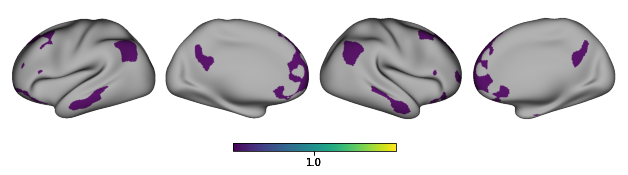

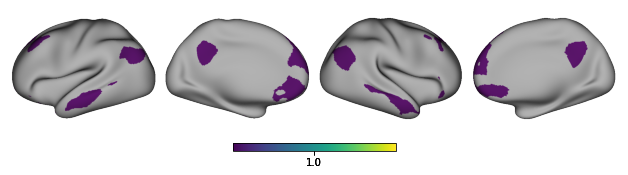

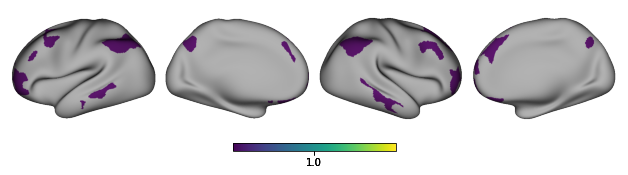

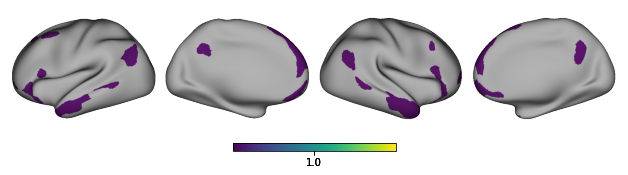

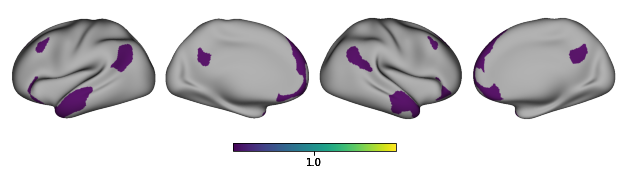

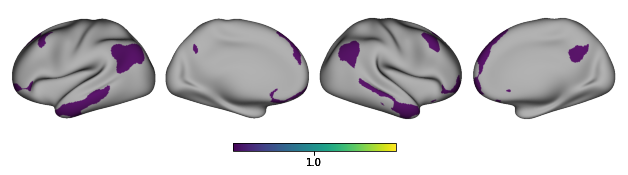

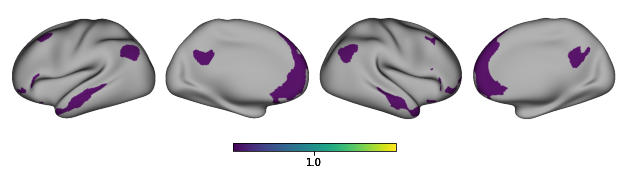

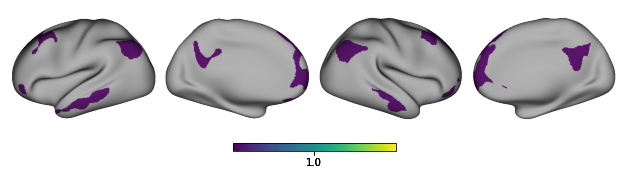

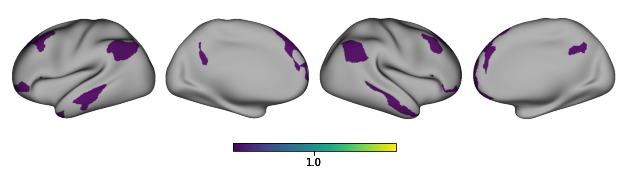

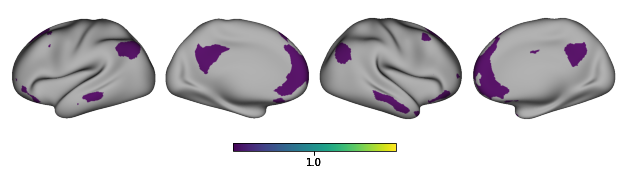

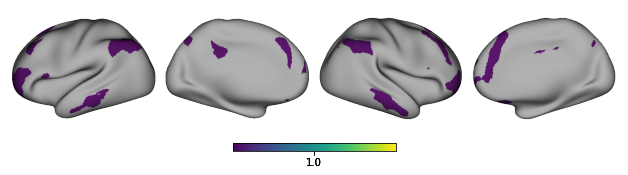

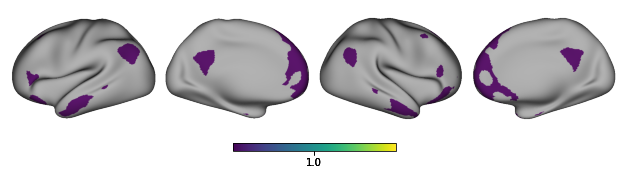

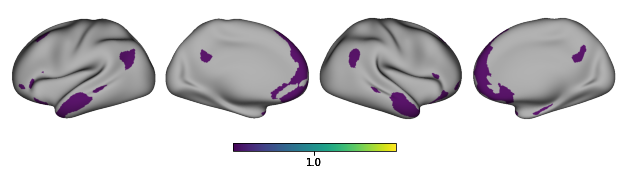

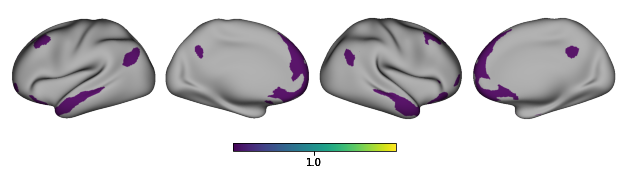

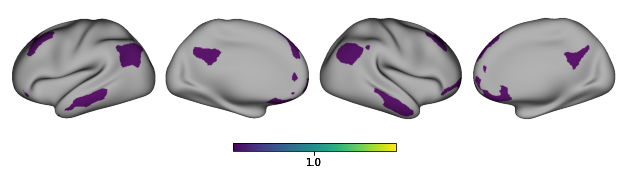

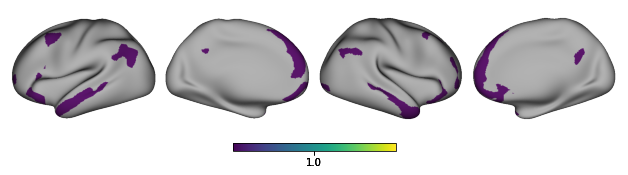

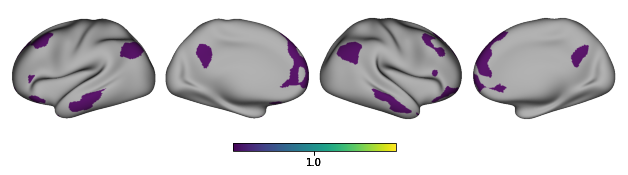

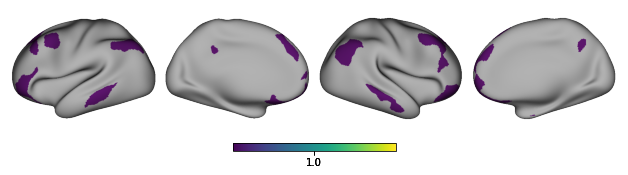

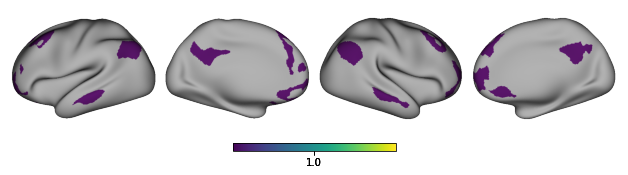

In [25]:
probmapL=[]
probmapR=[]
for key in sub_dict.copy():
    grads=sub_dict[key].extract_topX(sub_dict[key].Lgrad,sub_dict[key].Rgrad,threshold)
    lmap=np.zeros(sub_dict[key].dims)
    lmap[grads[0]]=1
    probmapL.append(lmap)
    rmap=np.zeros(sub_dict[key].dims)
    rmap[grads[1]]=1
    probmapR.append(rmap)
    
    
#     print(f'subject {key}')
    p = surfplot.Plot(surf_lh=lh, surf_rh=rh,layout='row',size=(1000,200))
    p.add_layer({'left': lmap, 'right': rmap}, cmap='viridis')
    fig = p.build()
    plt.savefig(f'fullgradPNGs/{key}.png',facecolor='w',bbox_inches='tight')
    

hide_toggle()
    
    
#     a,b=oh_mayavi(sub_dict[key].Linflated,lmap,'Set2',clrbar=False)
#     mlab.clf()
#     c,d=oh_mayavi(sub_dict[key].Rinflated,rmap,'Set2',clrbar=False)
#     mlab.clf()
#     plot_srfs(a,b,d,c,key)

#     print(key)
#     plt.imshow(a,b)

In [26]:
probmapL=np.vstack(probmapL).sum(axis=0)/len(probmapL)
probmapR=np.vstack(probmapR).sum(axis=0)/len(probmapR)

Gradient probability maps threshold at 90


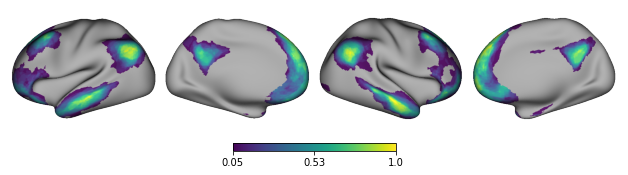

In [27]:
print(f'Gradient probability maps threshold at {threshold}')
p = surfplot.Plot(surf_lh=lh, surf_rh=rh,layout='row',size=(1000,200))
p.add_layer({'left': probmapL, 'right': probmapR}, cmap='viridis')
fig = p.build()
hide_toggle()

In [28]:
import subprocess as sp
import statsmodels.api as sm
from numba import jit

In [29]:
def DistFromGradMask(subj):
    grads=sub_dict[subj].extract_topX(sub_dict[subj].Lgrad,sub_dict[subj].Rgrad,threshold)
    Lsurf=[sub_dict[subj].Lcoords,sub_dict[subj].Lfaces]
    Ldist=surfdist.analysis.dist_calc(Lsurf,sub_dict[subj].Lfill,grads[0])
    
    Rsurf=[sub_dict[subj].Rcoords,sub_dict[subj].Rfaces]
    Rdist=surfdist.analysis.dist_calc(Rsurf,sub_dict[subj].Rfill,grads[1])
    
    ##### get the surface areas -- sqrt(sum of cortical vertex areas) 
    
    sp.run(f'wb_command -surface-vertex-areas {sub_dict[subj].Lsrf} L.area.func.gii',shell=True)
    Larea=np.sqrt(np.sum(nib.load('L.area.func.gii').darrays[0].data[sub_dict[subj].Lfill]))
    sp.run('rm L.area.func.gii',shell=True)
    
    
    sp.run(f'wb_command -surface-vertex-areas {sub_dict[subj].Rsrf} R.area.func.gii',shell=True)
    Rarea=np.sqrt(np.sum(nib.load('R.area.func.gii').darrays[0].data[sub_dict[subj].Rfill]))
    sp.run('rm R.area.func.gii',shell=True)
    
    

#     Lvolume=str(sp.check_output(f'mris_volume {sub_dict[subj].Lsrf}',shell=True))
#     Lvolume=np.float32(Lvolume.split('\\')[0].split('\'')[1])
        

#     Rvolume=str(sp.check_output(f'mris_volume {sub_dict[subj].Rsrf}',shell=True))
#     Rvolume=np.float32(Rvolume.split('\\')[0].split('\'')[1])
        
    return [Ldist,Larea,Rdist,Rarea]
    

In [30]:
distList=list(map(DistFromGradMask,sub_dict))

In [31]:
def correctAreaDiv(data):
    distL=np.vstack([x[0] for x in data])
    areaL=np.vstack([x[1] for x in data])
    corrL=distL/areaL
    
    distR=np.vstack([x[2] for x in data])
    areaR=np.vstack([x[3] for x in data])
    corrR=distR/areaR
    
    return corrL,corrR

In [32]:
cleaned_distance=list(correctAreaDiv(distList))

In [34]:
def scale_data(x):
#     norm=x+np.abs(np.min(x))
#     norm=norm/np.max(norm)
    return x*100 #norm #*100

In [35]:
l=list(map(scale_data,cleaned_distance[0]))
r=list(map(scale_data,cleaned_distance[1]))
cleaned_distance[0]=l
cleaned_distance[1]=r

In [36]:
Lmaps=np.vstack(cleaned_distance[0])
Lmaps=dict(zip(sub_dict.keys(),Lmaps))
Rmaps=np.vstack(cleaned_distance[1])
Rmaps=dict(zip(sub_dict.keys(),Rmaps))

In [41]:
L_hires=np.vstack(cleaned_distance[0])
R_hires=np.vstack(cleaned_distance[1])

In [42]:
maxiL=L_hires.max(axis=0)
maxiR=R_hires.max(axis=0)

In [43]:
stdL=L_hires.std(axis=0)
stdR=R_hires.std(axis=0)

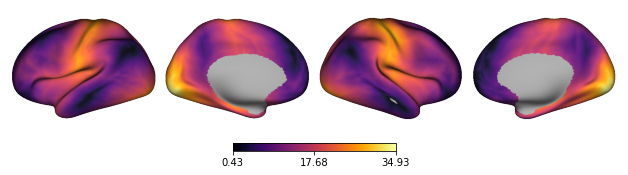

In [44]:
p = surfplot.Plot(surf_lh=lh, surf_rh=rh,layout='row',size=(1000,200))
p.add_layer({'left': maxiL, 'right': maxiR}, cmap='inferno')
fig = p.build()
plt.savefig('hiresMax32K.png',facecolor='w',bbox_inches='tight')

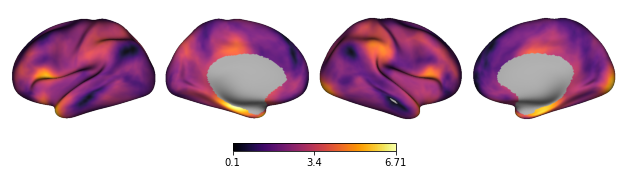

In [45]:
p = surfplot.Plot(surf_lh=lh, surf_rh=rh,layout='row',size=(1000,200))
p.add_layer({'left': stdL, 'right': stdR}, cmap='inferno')
fig = p.build()
plt.savefig('hiresSTD32K.png',facecolor='w',bbox_inches='tight')

In [49]:
from scipy import stats

In [50]:
Lglasser='GlasserParc/Glasser.32K.L.label.gii'
Rglasser='GlasserParc/Glasser.32K.R.label.gii'

In [51]:
SchaeferL100='SchaeferParc/Schaefer2018_100Parcels_7Networks_order.L.label.gii'
SchaeferR100='SchaeferParc/Schaefer2018_100Parcels_7Networks_order.R.label.gii'
SchaeferL200='SchaeferParc/Schaefer2018_200Parcels_17Networks_order.L.label.gii'
SchaeferR200='SchaeferParc/Schaefer2018_200Parcels_17Networks_order.R.label.gii'
SchaeferL300='SchaeferParc/Schaefer2018_300Parcels_17Networks_order.L.label.gii'
SchaeferR300='SchaeferParc/Schaefer2018_300Parcels_17Networks_order.R.label.gii'

In [52]:
def ParcelDistancesGrad(subj,data_dict,dist_dict,parc):
    parc=get_parcels(parc)
    
    stat_dict={}
    for key in parc:
        if key =='L_Medial_wall' or key == 'R_Medial_wall':
            pass
        else:
            roi=dist_dict[subj][parc[key]]
            mu=np.nanmean(roi)
            std=np.nanstd(roi)
            mini=np.nanmin(roi)
            maxi=np.nanmax(roi)
            med=np.nanmedian(roi)
            mode=int(stats.mode(np.round_(roi))[0])
            parcel_stats=[mu,std,mini,maxi,med,mode]
        
        
        stat_dict[key]=[parcel_stats][0]
        
    
    
    return parc,stat_dict
    
    

In [53]:
def parcelStat2Surf(data):
    parcVerts=data[0]
    stats=data[1]
    
    #### we want to create a surfmap for each of the stats we calculated
    measures={}
    statLabels=['mean','std','min','max','median','mode']
    for i in range(len(statLabels)):
        statmap=np.zeros(32492)
        for key in parcVerts:
            statmap[parcVerts[key]]=stats[key][i]
        measures[statLabels[i]]=statmap
    return measures

In [54]:
def get_stats(subjectDict,hemi,maps,parc=None):    
    subjectStats={}
    subject_SurfStats={}

    subjectMean=[]
    subjectStd=[]
    subjectMin=[]
    subjectMax=[]
    subjectMedian=[]
    subjectMode=[]

    for key in subjectDict:
        if parc==None:
            if hemi == 'L':
                parc=subjectDict[key].Laparc
            elif hemi =='R':
                parc=subjectDict[key].Raparc
        
        
        parcStats=ParcelDistancesGrad(key,sub_dict,maps,parc)
        subjectStats[key]=parcStats[1]
        subject_SurfStats[key]=parcelStat2Surf(parcStats)
    

        for pkey in parcStats[1]:
            subjectMean.append(parcStats[1][pkey][0])
            subjectStd.append(parcStats[1][pkey][1])
            subjectMin.append(parcStats[1][pkey][2])
            subjectMax.append(parcStats[1][pkey][3])
            subjectMedian.append(parcStats[1][pkey][4])
            subjectMode.append(parcStats[1][pkey][5])
    dim=len(subjectDict),len(parcStats[1])
    
    subjectMean=pd.DataFrame.from_dict(dict(zip(subject_SurfStats.keys(),np.hstack(subjectMean).reshape(dim))))
    subjectMean.set_axis(parcStats[1].keys(), axis=0,inplace=True)  

    subjectStd=pd.DataFrame.from_dict(dict(zip(subject_SurfStats.keys(),np.hstack(subjectStd).reshape(dim))))
    subjectStd.set_axis(parcStats[1].keys(), axis=0,inplace=True)   

    subjectMin=pd.DataFrame.from_dict(dict(zip(subject_SurfStats.keys(),np.hstack(subjectMin).reshape(dim))))
    subjectMin.set_axis(parcStats[1].keys(), axis=0,inplace=True)   

    subjectMax=pd.DataFrame.from_dict(dict(zip(subject_SurfStats.keys(),np.hstack(subjectMax).reshape(dim))))
    subjectMax.set_axis(parcStats[1].keys(), axis=0,inplace=True)   

    subjectMedian=pd.DataFrame.from_dict(dict(zip(subject_SurfStats.keys(),np.hstack(subjectMedian).reshape(dim))))
    subjectMedian.set_axis(parcStats[1].keys(), axis=0,inplace=True)   

    subjectMode=pd.DataFrame.from_dict(dict(zip(subject_SurfStats.keys(),np.hstack(subjectMode).reshape(dim))))
    subjectMode.set_axis(parcStats[1].keys(), axis=0,inplace=True)
    
    return subjectMean,subjectStd,subjectMin,subjectMax,subjectMedian,subjectMode,subject_SurfStats
    
    

In [55]:
def save_gifti(data,out):
    gi = nib.gifti.GiftiImage()
    da = nib.gifti.GiftiDataArray(np.float32(data), intent=0)
    gi.add_gifti_data_array(da)
    nib.save(gi,'%s.func.gii' % out)

In [56]:
def barplot_it(data):
    dat2plot=data
    labels=list(dat2plot.mean().sort_values().keys())
    ax_labels=[]
    for i in labels:
        ax_labels.append(i.replace('_',' ').replace('7Networks',''))
    
    
    dat2plot=dat2plot[labels]
    dat2plot.set_axis([labels],axis=1,inplace=True)
    
    if len(data) <80:
        f=plt.figure(figsize=(15,5))
    else:
        f=plt.figure(figsize=(30,5))
    ax1=sn.barplot(data=dat2plot,dodge=True,palette='inferno')
    ax1.set_xticklabels(ax_labels, rotation=90)
    sn.despine()
    return ax1

def mask_andPlot(data,hemi,modey,thr):
    modeOfModes=pd.DataFrame(modey.mode(axis=1)[0]).T
    
    mask=list(modeOfModes.T.loc[[modeOfModes.values>=thr][0][0]].index)
    out=data.copy()
    
    return barplot_it(out.T[mask])

In [57]:
!mkdir -p summaryMetrics

In [58]:
Lparc={'L.aparc.2009':None,'Glasser.L':Lglasser,'Schaefer.L.100':SchaeferL100,
       'Schaefer.L.200':SchaeferL200,'Schaefer.L.300':SchaeferL300}
Rparc={'R.aparc.2009':None,'Glasser.R':Rglasser,'Schaefer.R.100':SchaeferR100,
       'Schaefer.R.200':SchaeferR200,'Schaefer.R.300':SchaeferR300}

In [59]:
for i in Lparc.keys():
    out=i.replace('L.','')
    !mkdir -p summaryMetrics/{out}
    

In [554]:
LsubjStats=get_stats(sub_dict,'L',Lmaps)

In [555]:
tst=LsubjStats[3]

In [559]:
tst.rank()

,100206,100307,100408,100610,101006,101107,101309,101915,102008,102109,102311,102513,102614,102715,102816,103111,103212,103414,103515
L_G_and_S_frontomargin,4.0,4.0,2.0,8.0,21.0,2.0,17.0,5.0,3.0,16.0,14.0,19.0,15.0,6.0,2.0,9.0,5.0,5.0,5.0
L_G_and_S_occipital_inf,70.0,68.0,70.0,68.0,71.0,65.0,72.0,72.0,72.0,72.0,70.0,73.0,71.0,72.0,70.0,70.0,72.0,70.0,71.0
L_G_and_S_paracentral,59.0,48.0,55.0,49.0,60.0,63.0,52.0,50.0,58.0,45.0,51.0,55.0,59.0,57.0,52.0,58.0,55.0,52.0,49.0
L_G_and_S_subcentral,60.0,67.0,60.0,60.0,59.0,64.0,66.0,62.0,59.0,62.0,55.0,64.0,61.0,65.0,67.0,54.0,61.0,56.0,66.0
L_G_and_S_transv_frontopol,1.0,2.0,4.0,5.0,7.0,10.0,9.0,1.0,4.0,5.0,12.0,1.0,3.0,3.0,3.0,6.0,1.0,4.0,3.0
L_G_and_S_cingul-Ant,6.0,5.0,20.0,17.0,14.0,12.0,13.0,8.0,21.0,7.0,9.0,3.0,14.0,7.0,14.0,15.0,4.0,15.0,9.0
L_G_and_S_cingul-Mid-Ant,33.0,35.0,33.0,40.0,42.0,37.0,43.0,36.0,29.0,24.0,28.0,33.0,38.0,32.0,41.0,33.0,42.0,28.0,26.0
L_G_and_S_cingul-Mid-Post,42.0,38.0,53.0,41.0,46.0,52.0,39.0,31.0,50.0,25.0,24.0,39.0,40.0,48.0,37.0,41.0,44.0,32.0,27.0
L_G_cingul-Post-dorsal,20.0,8.0,42.0,16.0,19.0,32.0,14.0,3.0,16.0,1.0,4.0,14.0,17.0,28.0,1.0,21.0,17.0,14.0,1.0
L_G_cingul-Post-ventral,10.0,18.0,39.0,37.0,23.0,42.0,21.0,9.0,11.0,11.0,32.0,9.0,22.0,29.0,17.0,35.0,19.0,35.0,19.0


In [450]:
def sort_it(data):
    new=data.copy()
    rank=data.argsort()
    rank=new[rank].argsort().T
#     rank=rank.argsort().to_frame().T
#     rank=rank
    for key in rank.keys():
#         print(key,rank[key])
        new[key]=rank[key]
    return new

In [451]:
a=tst.apply(sort_it)
b=tst.apply(sort_it).T

In [452]:
from pyirr import kappam_fleiss 
from pyirr import intraclass_correlation

In [586]:
rankcount=tst.rank().T.melt().value_counts().to_frame()

In [611]:
rankcount

,,0
variable,value,
L_Pole_occipital,74.0,12
L_G_cuneus,69.0,11
L_G_oc-temp_med-Lingual,73.0,11
L_S_collat_transv_post,71.0,9
L_G_postcentral,68.0,8
L_S_oc-temp_med_and_Lingual,63.0,7
L_S_calcarine,72.0,7
L_Pole_occipital,73.0,6
L_G_and_S_occipital_inf,72.0,6


In [614]:
rankcount.pivot(columns='variable')

KeyError: "None of ['variable'] are in the columns"

In [562]:
kappam_fleiss(tst.rank(),exact=False,detail=True)

            Fleiss` Kappa for m Raters            
Subjects = 74
  Raters = 19
   Kappa = 0.057

       z = 54.666
 p-value = 0.000

          Kappa       z  p.value
0.013514  0.093  10.462    0.000
0.027027  0.040   4.461    0.000
0.040541  0.046   5.128    0.000
0.054054  0.046   5.128    0.000
0.067568  0.046   5.128    0.000
0.081081  0.040   4.461    0.000
0.094595  0.028   3.127    0.002
0.108108  0.022   2.460    0.014
0.121622  0.028   3.127    0.002
0.135135  0.028   3.127    0.002
0.148649  0.022   2.460    0.014
0.162162  0.016   1.793    0.073
0.175676  0.016   1.793    0.073
0.189189  0.040   4.461    0.000
0.202703  0.022   2.460    0.014
0.216216  0.028   3.127    0.002
0.229730  0.010   1.126    0.260
0.243243  0.022   2.460    0.014
0.256757  0.016   1.793    0.073
0.270270  0.010   1.126    0.260
0.283784  0.004   0.460    0.646
0.297297  0.016   1.793    0.073
0.310811 -0.002  -0.207    0.836
0.324324  0.034   3.794    0.000
0.337838  0.010   1.126    0.260
0.351351 

In [520]:
tst=a.iloc[a.T.std().argsort()]

In [523]:
labels=tst.T.keys()

In [541]:
tst=a.T.melt()

In [548]:
tst

,variable,value
0,L_G_and_S_frontomargin,3.0
1,L_G_and_S_frontomargin,3.0
2,L_G_and_S_frontomargin,1.0
3,L_G_and_S_frontomargin,7.0
4,L_G_and_S_frontomargin,20.0
5,L_G_and_S_frontomargin,1.0
6,L_G_and_S_frontomargin,16.0
7,L_G_and_S_frontomargin,4.0
8,L_G_and_S_frontomargin,2.0
9,L_G_and_S_frontomargin,15.0


In [553]:
f=plt.figure(figsize=(15,5))
ax=sn.stripplot(data=tst.T,palette='inferno')
ax.set_xticklabels(labels, rotation=90)
plt.show(ax)

ValueError: min() arg is an empty sequence

<Figure size 1080x360 with 0 Axes>

In [480]:
from sklearn.manifold import MDS

In [491]:
mdl=MDS(n_components=2)
tst=mdl.fit(a.T)

In [469]:
a.std(axis=1).sort_values()

L_Pole_occipital                0.606977
L_G_oc-temp_med-Lingual         0.764719
L_S_collat_transv_post          1.268143
L_S_calcarine                   1.583910
L_G_cuneus                      1.742150
L_G_and_S_occipital_inf         1.896442
L_S_central                     2.643540
L_S_oc-temp_med_and_Lingual     2.820145
L_G_occipital_sup               3.016524
L_G_and_S_transv_frontopol      3.167821
L_G_postcentral                 3.201790
L_S_interm_prim-Jensen          3.847229
L_G_and_S_subcentral            3.906809
L_G_oc-temp_lat-fusifor         4.030585
L_G_precuneus                   4.488452
L_G_precentral                  4.605489
L_S_circular_insula_inf         4.619435
L_S_oc_middle_and_Lunatus       4.787288
L_S_orbital-H_Shaped            4.787899
L_G_and_S_paracentral           4.801316
L_Lat_Fis-post                  4.933476
L_G_temp_sup-G_T_transv         5.187705
L_G_and_S_cingul-Ant            5.287080
L_G_front_sup                   5.419803
L_G_Ins_lg_and_S

In [470]:
a[a>40].dropna()

,100206,100307,100408,100610,101006,101107,101309,101915,102008,102109,102311,102513,102614,102715,102816,103111,103212,103414,103515
L_G_and_S_occipital_inf,69.0,67.0,69.0,67.0,70.0,64.0,71.0,71.0,71.0,71.0,69.0,72.0,70.0,71.0,69.0,69.0,71.0,69.0,70.0
L_G_and_S_paracentral,58.0,47.0,54.0,48.0,59.0,62.0,51.0,49.0,57.0,44.0,50.0,54.0,58.0,56.0,51.0,57.0,54.0,51.0,48.0
L_G_and_S_subcentral,59.0,66.0,59.0,59.0,58.0,63.0,65.0,61.0,58.0,61.0,54.0,63.0,60.0,64.0,66.0,53.0,60.0,55.0,65.0
L_G_cuneus,70.0,65.0,66.0,70.0,68.0,70.0,63.0,68.0,68.0,68.0,68.0,68.0,66.0,66.0,68.0,68.0,68.0,68.0,68.0
L_G_front_sup,55.0,52.0,58.0,45.0,57.0,58.0,50.0,46.0,54.0,42.0,43.0,48.0,48.0,53.0,47.0,47.0,53.0,42.0,43.0
L_G_Ins_lg_and_S_cent_ins,44.0,50.0,56.0,46.0,44.0,56.0,47.0,51.0,50.0,51.0,45.0,45.0,41.0,42.0,59.0,43.0,46.0,52.0,59.0
L_G_occipital_middle,61.0,43.0,63.0,57.0,55.0,46.0,49.0,56.0,59.0,62.0,64.0,55.0,56.0,52.0,46.0,63.0,56.0,56.0,47.0
L_G_occipital_sup,68.0,59.0,62.0,65.0,66.0,61.0,60.0,67.0,67.0,67.0,63.0,66.0,65.0,63.0,57.0,66.0,63.0,65.0,64.0
L_G_oc-temp_lat-fusifor,54.0,61.0,64.0,62.0,61.0,50.0,66.0,57.0,64.0,60.0,61.0,64.0,64.0,61.0,60.0,64.0,59.0,60.0,55.0
L_G_oc-temp_med-Lingual,72.0,72.0,72.0,73.0,72.0,73.0,70.0,72.0,72.0,72.0,73.0,71.0,72.0,72.0,73.0,72.0,72.0,73.0,73.0


In [406]:
intraclass_correlation(a,mtype='consistency')

          Intraclass Correlation Results          
Model: oneway
Type: consistency

Subjects = 74
Raters = 19
ICC(1) = 0.86

F-Test, H0: r0 = 0 ; H1 : r0 > 0
F(73.00,1332.00) = 117.73, p = 0.0000

95%-Confidence Interval for ICC Population Values:
0.818 < ICC < 0.898

In [433]:
from pyirr import read_data, kappam_fleiss

data = read_data("anxiety")  # loads example data
kappam_fleiss(data, detail=True)

            Fleiss` Kappa for m Raters            
Subjects = 20
  Raters = 3
   Kappa = -0.041

       z = -0.634
 p-value = 0.526

   Kappa      z  p.value
1 -0.080 -0.620    0.535
2 -0.023 -0.176    0.860
3 -0.111 -0.861    0.389
4  0.135  1.043    0.297
5 -0.071 -0.553    0.580
6 -0.071 -0.553    0.580

In [286]:
pd.set_option('display.max_rows', None)


In [287]:
sub1[sub1.argsort()].argsort()

L_S_suborbital                  0
L_G_subcallosal                 1
L_Lat_Fis-ant-Horizont          2
L_G_rectus                      3
L_S_subparietal                 4
L_S_interm_prim-Jensen          5
L_G_front_inf-Orbital           6
L_S_orbital_med-olfact          7
L_G_and_S_transv_frontopol      8
L_S_orbital_lateral             9
L_Lat_Fis-ant-Vertical         10
L_G_front_inf-Triangul         11
L_G_and_S_cingul-Ant           12
L_G_cingul-Post-dorsal         13
L_G_orbital                    14
L_S_circular_insula_ant        15
L_G_and_S_frontomargin         16
L_G_pariet_inf-Angular         17
L_S_orbital-H_Shaped           18
L_S_temporal_sup               19
L_G_cingul-Post-ventral        20
L_S_front_inf                  21
L_G_temp_sup-Lateral           22
L_Pole_temporal                23
L_S_front_middle               24
L_S_front_sup                  25
L_G_temporal_middle            26
L_S_parieto_occipital          27
L_S_cingul-Marginalis          28
L_G_temp_sup-P

In [288]:
sub1.sort_values()

L_S_suborbital                  0.904324
L_G_subcallosal                 3.355580
L_Lat_Fis-ant-Horizont          3.495598
L_G_rectus                      4.676051
L_S_subparietal                 4.883551
L_S_interm_prim-Jensen          4.884129
L_G_front_inf-Orbital           4.965076
L_S_orbital_med-olfact          5.199361
L_G_and_S_transv_frontopol      5.228598
L_S_orbital_lateral             5.308123
L_Lat_Fis-ant-Vertical          5.423526
L_G_front_inf-Triangul          5.620516
L_G_and_S_cingul-Ant            5.931881
L_G_cingul-Post-dorsal          6.051622
L_G_orbital                     6.192458
L_S_circular_insula_ant         6.226615
L_G_and_S_frontomargin          6.809534
L_G_pariet_inf-Angular          7.023315
L_S_orbital-H_Shaped            7.473427
L_S_temporal_sup               10.239098
L_G_cingul-Post-ventral        10.381685
L_S_front_inf                  10.449808
L_G_temp_sup-Lateral           10.548214
L_Pole_temporal                10.862530
L_S_front_middle

L_G_and_S_frontomargin          0.0
L_G_and_S_occipital_inf         1.0
L_G_and_S_paracentral           2.0
L_G_and_S_subcentral            3.0
L_G_and_S_transv_frontopol      4.0
L_G_and_S_cingul-Ant            5.0
L_G_and_S_cingul-Mid-Ant        6.0
L_G_and_S_cingul-Mid-Post       7.0
L_G_cingul-Post-dorsal          8.0
L_G_cingul-Post-ventral         9.0
L_G_cuneus                     10.0
L_G_front_inf-Opercular        11.0
L_G_front_inf-Orbital          12.0
L_G_front_inf-Triangul         13.0
L_G_front_middle               14.0
L_G_front_sup                  15.0
L_G_Ins_lg_and_S_cent_ins      16.0
L_G_insular_short              17.0
L_G_occipital_middle           18.0
L_G_occipital_sup              19.0
L_G_oc-temp_lat-fusifor        20.0
L_G_oc-temp_med-Lingual        21.0
L_G_oc-temp_med-Parahip        22.0
L_G_orbital                    23.0
L_G_pariet_inf-Angular         24.0
L_G_pariet_inf-Supramar        25.0
L_G_parietal_sup               26.0
L_G_postcentral             

In [30]:
for lp,rp in zip(Lparc.keys(),Rparc.keys()):
    print(lp,rp)
    out=lp.replace('L.','')
    
    ### get data ready to plot 
#     LsubjectMean,LsubjectStd,LsubjectMin,LsubjectMax,LsubjectMedian,\
#     LsubjectMode,Lsubject_SurfStats
    LsubjStats=get_stats(sub_dict,'L',Lmaps,parc=Lparc[lp])
#     RsubjectMean,RsubjectStd,RsubjectMin,RsubjectMax,RsubjectMedian,\
#     RsubjectMode,Rsubject_SurfStats
    RsubjStats=get_stats(sub_dict,'R',Rmaps,parc=Rparc[rp])
    
    ### place the data back into surface space 
    dfL=pd.DataFrame.from_dict(LsubjStats[6])
    dfR=pd.DataFrame.from_dict(RsubjStats[6])
    
    
    L_meanMetrics=[]
    R_meanMetrics=[]
    for i in dfL.index:
        L_meanMetrics.append(dfL.loc[i].mean())
        R_meanMetrics.append(dfR.loc[i].mean())
    L_meanMetrics=np.vstack(L_meanMetrics)
    R_meanMetrics=np.vstack(R_meanMetrics)
    
    
    save_gifti(L_meanMetrics.T,f'./summaryMetrics/{out}/{out}.LmetricMaps')
    save_gifti(R_meanMetrics.T,f'./summaryMetrics/{out}/{out}.RmetricMaps')
    
    metricIDX={'Mean':[0,5],'StandardDeviation':[1,1.2],'Min':[2,3],'Max':[3,10],'Median':[4,5],'Mode':[5,10]}

    for key in metricIDX:
        Lmetric=L_meanMetrics[metricIDX[key][0]]
        Lmetric[Lmetric<metricIDX[key][1]]=0
        Rmetric=R_meanMetrics[metricIDX[key][0]]
        Rmetric[Rmetric<metricIDX[key][1]]=0
        p = surfplot.Plot(surf_lh=lh, surf_rh=rh,layout='row',size=(1200,200),views=['lateral','medial'])
        p.add_layer({'left':Lmetric,'right':Rmetric }, cmap='inferno')
        fig = p.build()
        plt.title(f'{out} {key}')
        plt.savefig(f'./summaryMetrics/{out}/{out}.surf.{key}.png',facecolor='w',bbox_inches='tight')
        plt.close('all')
        
        lplot=mask_andPlot(LsubjStats[metricIDX[key][0]],'L',LsubjStats[metricIDX[key][0]],metricIDX[key][1])
        plt.savefig(f'./summaryMetrics/{out}/{out}.L.plot.{key}.png',facecolor='w',bbox_inches='tight')
        rplot=mask_andPlot(RsubjStats[metricIDX[key][0]],'R',RsubjStats[metricIDX[key][0]],metricIDX[key][1])
        plt.savefig(f'./summaryMetrics/{out}/{out}.R.plot.{key}.png',facecolor='w',bbox_inches='tight')
        plt.close('all')

L.aparc.2009 R.aparc.2009
Glasser.L Glasser.R
Schaefer.L.100 Schaefer.R.100
Schaefer.L.200 Schaefer.R.200
Schaefer.L.300 Schaefer.R.300


Context leak detected, msgtracer returned -1


In [31]:
dirs=!ls summaryMetrics/

In [32]:
dirs

['Glasser.L',
 'Schaefer.100',
 'Schaefer.200',
 'Schaefer.300',
 'SummaryMetrics.pdf',
 'aparc.2009']

In [33]:
!ls summaryMetrics/aparc.2009/

aparc.2009.L.plot.Max.png               aparc.2009.R.plot.Mean.png
aparc.2009.L.plot.Mean.png              aparc.2009.R.plot.Median.png
aparc.2009.L.plot.Median.png            aparc.2009.R.plot.Min.png
aparc.2009.L.plot.Min.png               aparc.2009.R.plot.Mode.png
aparc.2009.L.plot.Mode.png              aparc.2009.R.plot.StandardDeviation.png
aparc.2009.L.plot.StandardDeviation.png aparc.2009.RmetricMaps.func.gii
aparc.2009.LmetricMaps.func.gii         aparc.2009.StandardDeviation.png
aparc.2009.Max.png                      aparc.2009.surf.Max.png
aparc.2009.Mean.png                     aparc.2009.surf.Mean.png
aparc.2009.Median.png                   aparc.2009.surf.Median.png
aparc.2009.Min.png                      aparc.2009.surf.Min.png
aparc.2009.Mode.png                     aparc.2009.surf.Mode.png
aparc.2009.R.plot.Max.png               aparc.2009.surf.StandardDeviation.png


In [34]:
for i in dirs:
    for key in metricIDX:
        cmd=f'convert -append summaryMetrics/{i}/{i}.surf.{key}.png summaryMetrics/{i}/{i}.L.plot.{key}.png \
        summaryMetrics/{i}/{i}.R.plot.{key}.png summaryMetrics/{i}/{i}.{key}.png'
        sp.run(cmd,shell=True)
#     remove=f'rm summaryMetrics/{i}/*plot* summaryMetrics/{i}/*surf*'
#     sp.run(remove,shell=True)
    

convert: unable to open image 'summaryMetrics/SummaryMetrics.pdf/SummaryMetrics.pdf.surf.Mean.png': Not a directory @ error/blob.c/OpenBlob/3527.
convert: unable to open image 'summaryMetrics/SummaryMetrics.pdf/SummaryMetrics.pdf.L.plot.Mean.png': Not a directory @ error/blob.c/OpenBlob/3527.
convert: unable to open image 'summaryMetrics/SummaryMetrics.pdf/SummaryMetrics.pdf.L.plot.Mean.png': Not a directory @ error/blob.c/OpenBlob/3527.
convert: unable to open image 'summaryMetrics/SummaryMetrics.pdf/SummaryMetrics.pdf.R.plot.Mean.png': Not a directory @ error/blob.c/OpenBlob/3527.
convert: unable to open image 'summaryMetrics/SummaryMetrics.pdf/SummaryMetrics.pdf.R.plot.Mean.png': Not a directory @ error/blob.c/OpenBlob/3527.
convert: no images defined `summaryMetrics/SummaryMetrics.pdf/SummaryMetrics.pdf.Mean.png' @ error/convert.c/ConvertImageCommand/3325.
convert: unable to open image 'summaryMetrics/SummaryMetrics.pdf/SummaryMetrics.pdf.surf.StandardDeviation.png': Not a director

In [ ]:
def colormeLabel(prc):
    prc_file=nib.load(prc)
    prc=prc_file.labeltable.get_labels_as_dict()
    prc2 = {v: k for k, v in prc.items()}
    return prc2

In [ ]:
def vertUnique2Parcel(hemi):
    outer=[]
    for key in sub_dict:
        if hemi =='L':
            mini=get_parcels(sub_dict[key].Laparc)
            colors=colormeLabel(sub_dict[key].Laparc)
            
        elif hemi=='R':
            mini=get_parcels(sub_dict[key].Raparc)
            colors=colormeLabel(sub_dict[key].Raparc)
            
        tmp=[]
        for pkey in mini:
            tmp.append(mini[pkey])
        outer.append(tmp)
    verts=np.vstack(outer)
    verts=verts.T
    XsubjPArcels=dict(zip(mini.keys(),verts))
    
    XsubjUnique={}
    for key in XsubjPArcels:
        XsubjUnique[key]=np.unique(np.hstack(XsubjPArcels[key]))
        
    uq={}
    for key in XsubjUnique:
        copy=XsubjUnique.copy()
        del copy[key]
        uq[key]=np.setdiff1d(XsubjUnique[key],np.hstack(copy.values()))
        
        
    out=np.zeros(32492)
    for key in uq:
        out[uq[key]]=colors[key]
    return out,colors

In [ ]:
Lunique,clrKeyL=vertUnique2Parcel('L')
Runique,clrKeyR=vertUnique2Parcel('R')

In [ ]:
nilearn.plotting.view_surf(str(lh),Lunique,cmap='viridis',symmetric_cmap=False,threshold=0.01)

In [ ]:
nilearn.plotting.view_surf(str(rh),Runique,cmap='viridis',symmetric_cmap=False,threshold=0.01)

In [ ]:
##### function to save gifti labels 
def save_gifti_label(data,LabelDict,colors,out): 
    gi = nib.gifti.GiftiImage()
    
    #### create the gifti labels here
    LabTab=[]
    for key in LabelDict:
        print(key)
        print(LabelDict[key])
        val=LabelDict.get(key)
        inter=nib.gifti.gifti.GiftiLabel(colors[val][0],colors[val][1],colors[val][2],colors[val][3])
        print(inter)
        inter.label=key
        LabTab.append(inter)
    return LabTab
    
    
#     gi.labeltable.labels=LabTab
#     ### the label data is independent from the data array 
    
#     if len(data.shape)!=1:
#         for i in range(data.shape[0]):
#             da = nib.gifti.GiftiDataArray(np.float32(data[i]), intent=0)
#             gi.add_gifti_data_array(da)
#         nib.save(gi,f'{out}.label.gii')
#     else:
#         da = nib.gifti.GiftiDataArray(np.float32(data), intent=0)
#         gi.add_gifti_data_array(da)
#         nib.save(gi,f'{out}.label.gii')

In [ ]:
a=save_gifti_label(Lunique,clrKeyL,Lcolors,'test')

In [ ]:
tst=nib.load(sub_dict['100206'].Laparc)

In [ ]:
val=list(set(Lunique))

In [ ]:
Lcolors=[]
for i in val:
    Lcolors.append(list(tst.labeltable.labels[int(i)].get_rgba()))
# Lcolors[0]=[0.0, 0.0, 0.0, 0.0,0.0]

In [ ]:
out[uq['L_G_temp_sup-G_T_transv']]=100
out[uq['L_S_calcarine']]=100
out[uq['L_S_central']]=100
out[uq['L_S_temporal_transverse']]=110
out[uq['L_Pole_occipital']]=110

In [ ]:
#### questions to ask / do 
## do the regresssion / cleaning only including cortical vertices
## create a group mask of medial wall and mask out prior to calculating anything
## create a group mask of top 10% in gradient. it currently keeps us 

In [ ]:
#### do the consistency analysis??? 

In [ ]:
#### code snippet to save / reuse for correcting with linear regression
from sklearn.linear_model import LinearRegression

def regressOutArea(data):
    ### do left 
    distL=np.vstack([x[0] for x in data])
    volL=np.vstack([x[1] for x in data])
    
    mdlL=LinearRegression().fit(volL,distL)
#     pL=mdlL.predict(volL)
    
    ### correction as https://www.sciencedirect.com/science/article/pii/S105381190900487X?via=ihub
    LdistCorrected=distL-(volL*mdlL.coef_.T)
    
    #### do right 
    distR=np.vstack([x[2] for x in data])
    volR=np.vstack([x[3] for x in data])
    
    mdlR=LinearRegression().fit(volR,distR)
#     pR=mdlR.predict(volR)
    RdistCorrected=distR-(volR*mdlR.coef_.T)


    return LdistCorrected,RdistCorrected